<a href="https://colab.research.google.com/github/Chay16/Plant-Pathology-FGVC7/blob/master/Kaggle_Plant_Pathology_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FGVV7 Plant Pathology 2020 Competition
Chayan Toufan Tabrizi

---



## Environment Setup

Importing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Global Variables

In [0]:
DRIVE_DIR = "/content/drive/My Drive/DATASETS/plant-pathology-2020-fgvc7"
DATA_DIR = "/content/"
CATEGORIES = ['healthy', "multiple_diseases", "rust", "scab"]
IMG_SHAPE = (2048,1365)
TRAINVAL_RATIO = 0.8

BATCH_SIZE = 16

Importing Librairies

In [0]:
import os
import time
import shutil

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tq

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models,transforms,datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import itertools

%matplotlib inline

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using GPU: %s ' % torch.cuda.is_available())

Using GPU: True 


## ImageFolder Dataset

Very Slow Computation to create the right folder architecture, one may prefer to use the custom dataset implementation to avoid these computations

In [0]:
traindf = pd.read_csv(os.path.join(DRIVE_DIR,"train_original.csv"))
testdf = pd.read_csv(os.path.join(DRIVE_DIR,"test.csv"))

In [0]:
traindf = traindf.sample(n=len(traindf))
validdf = traindf[int(TRAINVAL_RATIO*len(traindf)):]
traindf = traindf[:int(TRAINVAL_RATIO*len(traindf))]

In [0]:
train_image_id_classes = {}
valid_image_id_classes = {}
for categ in tq(CATEGORIES):
    train_image_id_classes[categ] = list(traindf.loc[traindf[categ]==1,"image_id"])
    valid_image_id_classes[categ] = list(validdf.loc[validdf[categ]==1,"image_id"])



We first create three directories where we will put images form the training and validation sets as described below :
```bash
plant-pathology-2020-fbvc7
├── train
|   └── healthy   # contains images of healthy plants from the trainig set
|   └── multiple_diseases   # contains images of plants with multiple diseases
|   └── rust   # contains images of plants with rust
|   └── scab   # contains images of plants with scab 
├── valid
|   └── healthy   # contains images of healthy plants from the validation set
|   └── multiple_diseases   # contains images of plants with multiple diseases
|   └── rust   # contains images of plants with rust
|   └── scab   # contains images of plants with scab
├── test
|   └── healthy   # contains images of healthy plants from the testing set
|   └── multiple_diseases   # contains images of plants with multiple diseases
|   └── rust   # contains images of plants with rust
|   └── scab   # contains images of plants with scab

```

In [0]:
%%time

def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

# Slow ==> 11 min
for categ in tq(CATEGORIES, desc="Train / Valid Folders"):
    for idx in train_image_id_classes[categ]:
        check_dir(os.path.join(DATA_DIR, "train", categ))
        shutil.copyfile(os.path.join(DRIVE_DIR, "images", "{}.jpg".format(idx)),
                        os.path.join(DATA_DIR, "train", categ, "{}.jpg".format(idx)))
    for idx in valid_image_id_classes[categ]:
        check_dir(os.path.join(DATA_DIR, "valid", categ))
        shutil.copyfile(os.path.join(DRIVE_DIR, "images", "{}.jpg".format(idx)),
                        os.path.join(DATA_DIR, "valid", categ, "{}.jpg".format(idx)))
for idx in tq(testdf['image_id'].tolist(), desc="Test Folder"):
    check_dir(os.path.join(DATA_DIR, "test"))
    shutil.copyfile(os.path.join(DRIVE_DIR, "images", "{}.jpg".format(idx)),
                    os.path.join(DATA_DIR, "test", "{}.jpg".format(idx)))


CPU times: user 4.98 s, sys: 3.75 s, total: 8.73 s
Wall time: 13min 21s


In [0]:
dsets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), imagenet_format)
         for x in ['train', 'valid']}
dset_classes = dsets['train'].classes
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
print("Classes :", dset_classes)
print("Sizes :", dset_sizes)

Classes : ['healthy', 'multiple_diseases', 'rust', 'scab']
Sizes : {'train': 1456, 'valid': 365}


In [0]:
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

imagenet_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize_imagenet,
            ])

In [0]:
dataloader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)
dataloader_valid = torch.utils.data.DataLoader(dsets['valid'], batch_size=5, shuffle=False, num_workers=6)

## Custom Dataset

In [0]:
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms_imagenet = transforms.Compose([
                                          transforms.CenterCrop(512),
                                          transforms.ToTensor(),
                                          normalize_imagenet,
                                          ])

In [0]:
class PlantDataset(torch.utils.data.Dataset):

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        img_path = os.path.join(DRIVE_DIR,'images', "{}.jpg".format(self.df.loc[i, 'image_id']))
        image = Image.open(img_path)
        if self.transforms:
            image = self.transforms(image)

        label = self.df.loc[i,CATEGORIES].values
        label = torch.from_numpy(label.astype(np.uint8))
        label = torch.max(label,0)[1].item()

        return image, label

In [0]:
testdf = pd.read_csv(os.path.join(DRIVE_DIR,"test.csv"))
for categ in CATEGORIES:
    testdf[categ]=0

In [0]:
dataset_test = PlantDataset(df=testdf, transforms=transforms_imagenet)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=5, num_workers=6, shuffle=False)

In [0]:
traindf = pd.read_csv(os.path.join(DRIVE_DIR,"train_original.csv"))
traindf = traindf.sample(n=len(traindf))
validdf = traindf[int(TRAINVAL_RATIO*len(traindf)):].reset_index(drop=True)
traindf = traindf[:int(TRAINVAL_RATIO*len(traindf))].reset_index(drop=True)

In [0]:
class_sample_count = traindf[CATEGORIES].sum(axis=0)
weights = np.sum(class_sample_count)/class_sample_count.values
weights = torch.FloatTensor(weights).to(DEVICE)

In [0]:
dataset_train = PlantDataset(df=traindf, transforms=transforms_imagenet)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, num_workers=6, shuffle=True)

dataset_valid = PlantDataset(df=validdf, transforms=transforms_imagenet)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=5, num_workers=6, shuffle=False)

dset_sizes = {'train': len(dataset_train),
             'valid': len(dataset_valid),
             'test': len(dataset_test)}
idx_to_classes = {i:categ for i, categ in enumerate(CATEGORIES)}

In [0]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4034, 0.5123, 0.3125])
    std = np.array([0.1908, 0.1751, 0.1728])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

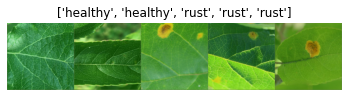

In [15]:
inputs_try, labels_try = next(iter(dataloader_train))
n_images = 5
out = torchvision.utils.make_grid(inputs_try[0:n_images])


imshow(out, title=[idx_to_classes[x.item()] for x in labels_try[0:n_images]])

In [16]:
inputs_try.size()

torch.Size([16, 3, 512, 512])

## Help Functions

### Compute ResNet Features

In [0]:
def preconvfeat_resnet(dataloader, resnet):
    conv_features = []
    labels_list = []
    for data in tq(dataloader, desc="Compute ResNet Features"):
        inputs,labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        x = resnet.conv1(inputs)
        x = resnet.bn1(x)
        x = resnet.relu(x)
        x = resnet.maxpool(x)
        x = resnet.layer1(x)
        x = resnet.layer2(x)
        x = resnet.layer3(x)
        x = resnet.layer4(x)
        x = resnet.avgpool(x)

        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

### Evaluate Model

In [0]:
def eval_model(model, dataloader, size, criterion, verbose=True):
    model.eval()
    start = time.time()
    
    running_loss, running_corrects = 0.0, 0

    for data, labels in dataloader:
            
            data = data.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(data)

            loss = criterion(outputs, labels)
            
            _,preds = torch.max(outputs.data,1)

            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    
    if verbose:
        print('Validation Metrics - Loss: {:.4f} Acc: {:.4f} Time: {}'.format(
                    epoch_loss, epoch_acc, 
                    time.strftime("%M:%S", time.localtime(time.time()-start))))
    
    return epoch_loss, epoch_acc

### Train Model

In [0]:
def train_model(model, best_model, trainloader, validationloader, train_size, valid_size, criterion, optimizer, epochs=10, verbose=True, checkpoints=False, savedir=None, modelname=None):
    if checkpoints:
        assert(savedir != None and modelname != None)

    model.train()
    start = time.time()
    losses_train, acc_train = [], []
    losses_val, acc_val = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0

        for inputs,labels in trainloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)

            loss = criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _,preds = torch.max(outputs.data,1)
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.data.item() / train_size
        losses_train.append(epoch_loss)
        acc_train.append(epoch_acc)

        epoch_loss_val, epoch_acc_val = eval_model(model, validationloader, valid_size, criterion, verbose=False)
        losses_val.append(epoch_loss_val)
        acc_val.append(epoch_acc_val)

        if verbose:
            if ((epoch+1) % 5) == 0 or epoch == 0:
                print('Epochs {}/{} ({:.1f}%) - Loss: {:.4f} Acc: {:.4f} Time: {}'.format(
                        epoch+1, epochs, (epoch+1)/epochs *100, 
                        epoch_loss, epoch_acc, 
                        time.strftime("%M:%S", time.localtime(time.time()-start))))
                print('Validation Metrics - Loss: {:.4f} Acc: {:.4f}'.format(
                    epoch_loss_val, epoch_acc_val))

        if (epoch == 0) :
            best_acc = epoch_acc_val
            best_model.load_state_dict(model.state_dict())
        
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model.load_state_dict(model.state_dict())

        if checkpoints:
            if (epoch >= 2) and (epoch_acc_val > best_acc):
                model_path = os.path.join(savedir,'{}.pth'.format(modelname))
                torch.save({'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss_train': losses_train,
                            'acc_train': acc_train,
                            'loss_val': losses_val,
                            'acc_val': acc_val},
                            model_path)
                print("Checkpoints at epoch {} saved at {}".format(epoch+1,model_path))
    print("")
    print("Best Model :")
    best_model.to(DEVICE)
    best_loss_val, best_acc_val = eval_model(best_model, validationloader, valid_size, criterion, verbose=True)

    return best_model, losses_train, acc_train, losses_val, acc_val

### Test Model

In [0]:
def test_model(model, dataloader, size, criterion, test=False):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,4))

    i = 0
    running_loss = 0.0
    running_corrects = 0

    for inputs,labels in tq(dataloader, desc="Predictions"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)

        _,preds = torch.max(outputs.data,1)

        if not test:
            loss = criterion(outputs,labels)           
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == labels)
            all_classes[i:i+len(inputs)] = labels.to('cpu').numpy()

        predictions[i:i+len(inputs)] = preds.to('cpu').numpy()
        all_proba[i:i+len(inputs),:] = outputs.data.to('cpu').numpy()
        i += len(inputs)

    if not test:
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                        epoch_loss, epoch_acc))
        return predictions, all_proba, all_classes
    else:
        return predictions, all_proba

### Confusion Matrix

In [0]:
def make_fig_cm(cm):
    fig = plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(len(CATEGORIES));
    plt.xticks(tick_marks, CATEGORIES, rotation=90);
    plt.yticks(tick_marks, CATEGORIES, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

### Train One Fold

In [0]:
def train_one_fold(i_fold, model, criterion, optimizer, epochs, dataloader_train, dataloader_valid, train_size, valid_size):
    
    train_fold_results = []

    for epoch in tq(range(epochs), desc="Training Fold"):

        model.train()
        tr_loss = 0

        for step, batch in enumerate(dataloader_train):

            inputs = batch[0]
            labels = batch[1]

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds = None
        val_labels = None
        running_corrects = 0

        for step, batch in enumerate(dataloader_valid):
            inputs = batch[0]
            labels = batch[1]

            if val_labels is None:
                val_labels = labels.clone()
            else:
                val_labels = torch.cat((val_labels, labels), dim=0)

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.no_grad():
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs.data, dim=1)
                running_corrects += torch.sum(preds == labels)

                preds = preds.data.cpu()

                if val_preds is None:
                    val_preds = preds
                else:
                    val_preds = torch.cat((val_preds, preds), dim=0)
   
        train_fold_results.append({
            'fold': i_fold,
            'epoch': epoch,
            'train_loss': tr_loss / train_size,
            'valid_loss': val_loss / valid_size,
            'valid_acc': running_corrects.data.item() / valid_size,
        })

    return val_preds, train_fold_results

### Submission File

In [0]:
def create_submission_file(all_proba, modelname):
    submissiondf = pd.read_csv(os.path.join(DRIVE_DIR,"sample_submission.csv"))
    submissiondf.iloc[:,1:] = 0
    proba = torch.softmax(torch.from_numpy(all_proba), dim=1).cpu().numpy()
    submissiondf[CATEGORIES]=proba
    submissiondf.to_csv(os.path.join(DRIVE_DIR,"submission-{}.csv".format(modelname)), index=False)



## ResNet34 Fine Tuning

In [156]:
resnet34 = models.resnet34(pretrained=True)
resnet34.to(DEVICE);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [157]:
%%time
conv_feat34_train,labels34_train = preconvfeat_resnet(dataloader_train, resnet34)
conv_feat34_valid,labels34_valid = preconvfeat_resnet(dataloader_valid, resnet34)


CPU times: user 24.1 s, sys: 15.2 s, total: 39.3 s
Wall time: 53.1 s


In [0]:
dtype=torch.float

datasetfeat34_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat34_train,labels34_train)]
datasetfeat34_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat34_train]
loaderfeat34_train = torch.utils.data.DataLoader(datasetfeat34_train, batch_size=24, shuffle=True)

datasetfeat34_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat34_valid,labels34_valid)]
datasetfeat34_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat34_valid]
loaderfeat34_valid = torch.utils.data.DataLoader(datasetfeat34_valid, batch_size=16, shuffle=False)

In [0]:
resnet34_finetuned = nn.Sequential(nn.Linear(512,len(CATEGORIES)),
                                   nn.LogSoftmax(dim=1))
resnet34_finetuned.to(DEVICE)

criterion = nn.NLLLoss(weight=weights)
lr = 1e-4
optimizer_resnet34 = torch.optim.Adam(resnet34_finetuned.parameters(), lr=lr)

In [187]:
%%time
best_model_resnet34 = nn.Sequential(nn.Linear(512, len(CATEGORIES)),
                                   nn.LogSoftmax(dim=1))

best_model_resnet34, losses_train, acc_train, losses_val, acc_val = train_model(resnet34_finetuned,
                                                                       best_model_resnet34,
                                                                       loaderfeat34_train,
                                                                       loaderfeat34_valid,
                                                                       dset_sizes['train'],
                                                                       dset_sizes['valid'],
                                                                       criterion,
                                                                       optimizer_resnet34,
                                                                       50)

Epochs 1/50 (2.0%) - Loss: 0.0550 Acc: 0.4190 Time: 00:00
Validation Metrics - Loss: 0.0714 Acc: 0.5562
Epochs 5/50 (10.0%) - Loss: 0.0337 Acc: 0.7390 Time: 00:00
Validation Metrics - Loss: 0.0566 Acc: 0.6904
Epochs 10/50 (20.0%) - Loss: 0.0277 Acc: 0.8084 Time: 00:01
Validation Metrics - Loss: 0.0526 Acc: 0.7425
Epochs 15/50 (30.0%) - Loss: 0.0241 Acc: 0.8242 Time: 00:01
Validation Metrics - Loss: 0.0533 Acc: 0.6438
Epochs 20/50 (40.0%) - Loss: 0.0218 Acc: 0.8413 Time: 00:02
Validation Metrics - Loss: 0.0481 Acc: 0.7452
Epochs 25/50 (50.0%) - Loss: 0.0203 Acc: 0.8359 Time: 00:02
Validation Metrics - Loss: 0.0496 Acc: 0.6904
Epochs 30/50 (60.0%) - Loss: 0.0193 Acc: 0.8537 Time: 00:03
Validation Metrics - Loss: 0.0482 Acc: 0.7342
Epochs 35/50 (70.0%) - Loss: 0.0175 Acc: 0.8640 Time: 00:03
Validation Metrics - Loss: 0.0492 Acc: 0.7151
Epochs 40/50 (80.0%) - Loss: 0.0168 Acc: 0.8709 Time: 00:04
Validation Metrics - Loss: 0.0470 Acc: 0.7452
Epochs 45/50 (90.0%) - Loss: 0.0159 Acc: 0.8674 T

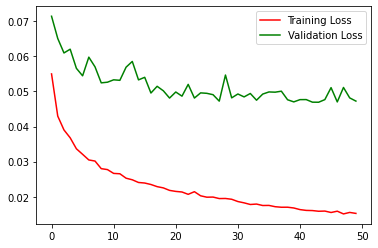

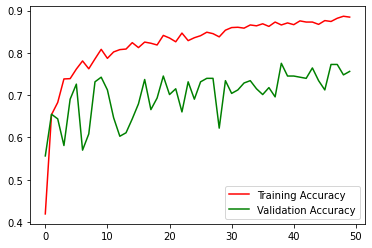

In [188]:
plt.figure()
plt.plot(range(len(losses_train)),losses_train,color="red",label="Training Loss")
plt.plot(range(len(losses_val)),losses_val,color="green",label="Validation Loss")
_ = plt.legend(loc='best')

plt.figure()
plt.plot(range(len(acc_train)),acc_train,color="red",label="Training Accuracy")
plt.plot(range(len(acc_val)),acc_val,color="green",label="Validation Accuracy")
_ = plt.legend(loc='best')

In [0]:
LOAD = False

if LOAD:
    checkpoint = torch.load(os.path.join(DRIVE_DIR,'resnet34.pth'))
    model = nn.Sequential(resnet34,
                          nn.LogSoftmax(dim=1))
    model.load_state_dict(checkpoint['model_state_dict'])

    model.to(DEVICE)


Loss: 0.0476 Acc: 0.7753


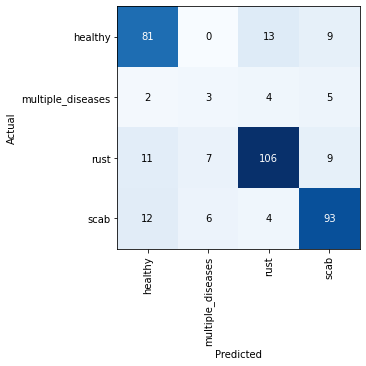

In [190]:
predictions, all_proba, all_classes = test_model(best_model_resnet34,
                                                 loaderfeat34_valid,
                                                 dset_sizes['valid'],
                                                 criterion)
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [0]:
conv_feat34_test,labels34_test = preconvfeat_resnet(dataloader_test, resnet34)

datasetfeat34_test = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat34_test,labels34_test)]
datasetfeat34_test = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat34_test]
loaderfeat34_test = torch.utils.data.DataLoader(datasetfeat34_test, batch_size=5, shuffle=False)

predictions, all_proba = test_model(best_model_resnet34,
                                    loaderfeat34_test,
                                    dset_sizes['test'],
                                    criterion,
                                    test=True)

create_submission_file(all_proba, "resnet34")




## ResNet50 Fine Tuning

In [0]:
resnet50 = models.resnet50(pretrained=True)
resnet50.to(DEVICE);

In [220]:
%%time
conv_feat50_train,labels50_train = preconvfeat_resnet(dataloader_train, resnet50)
conv_feat50_valid,labels50_valid = preconvfeat_resnet(dataloader_valid, resnet50)


CPU times: user 48.2 s, sys: 32 s, total: 1min 20s
Wall time: 1min 24s


In [0]:
dtype=torch.float

datasetfeat50_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat50_train,labels50_train)]
datasetfeat50_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat50_train]
loaderfeat50_train = torch.utils.data.DataLoader(datasetfeat50_train, batch_size=24, shuffle=True)

datasetfeat50_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat50_valid,labels50_valid)]
datasetfeat50_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat50_valid]
loaderfeat50_valid = torch.utils.data.DataLoader(datasetfeat50_valid, batch_size=16, shuffle=False)

In [0]:
resnet50_finetuned = nn.Sequential(nn.Linear(2048, len(CATEGORIES)),
                                   nn.LogSoftmax(dim=1))
resnet50_finetuned.to(DEVICE)

criterion = nn.NLLLoss(weight=weights)
lr = 1e-4
optimizer_resnet50 = torch.optim.Adam(resnet50_finetuned.parameters(), lr=lr)

In [226]:
%%time
best_model_resnet50 = nn.Sequential(nn.Linear(2048, len(CATEGORIES)),
                                   nn.LogSoftmax(dim=1))
best_model_resnet50, losses_train, acc_train, losses_val, acc_val = train_model(resnet50_finetuned,
                                                                       best_model_resnet50,
                                                                       loaderfeat50_train,
                                                                       loaderfeat50_valid,
                                                                       dset_sizes['train'],
                                                                       dset_sizes['valid'],
                                                                       criterion,
                                                                       optimizer_resnet50,
                                                                       200,
                                                                       verbose=True)

Epochs 1/200 (0.5%) - Loss: 0.0572 Acc: 0.3819 Time: 00:00
Validation Metrics - Loss: 0.0826 Acc: 0.5151
Epochs 5/200 (2.5%) - Loss: 0.0462 Acc: 0.6861 Time: 00:00
Validation Metrics - Loss: 0.0705 Acc: 0.6685
Epochs 10/200 (5.0%) - Loss: 0.0400 Acc: 0.7335 Time: 00:01
Validation Metrics - Loss: 0.0648 Acc: 0.6712
Epochs 15/200 (7.5%) - Loss: 0.0364 Acc: 0.7672 Time: 00:01
Validation Metrics - Loss: 0.0609 Acc: 0.6712
Epochs 20/200 (10.0%) - Loss: 0.0339 Acc: 0.7775 Time: 00:02
Validation Metrics - Loss: 0.0597 Acc: 0.6274
Epochs 25/200 (12.5%) - Loss: 0.0325 Acc: 0.7658 Time: 00:02
Validation Metrics - Loss: 0.0559 Acc: 0.7068
Epochs 30/200 (15.0%) - Loss: 0.0309 Acc: 0.7953 Time: 00:03
Validation Metrics - Loss: 0.0548 Acc: 0.7096
Epochs 35/200 (17.5%) - Loss: 0.0295 Acc: 0.7988 Time: 00:03
Validation Metrics - Loss: 0.0538 Acc: 0.6877
Epochs 40/200 (20.0%) - Loss: 0.0286 Acc: 0.7974 Time: 00:04
Validation Metrics - Loss: 0.0532 Acc: 0.7288
Epochs 45/200 (22.5%) - Loss: 0.0274 Acc: 0

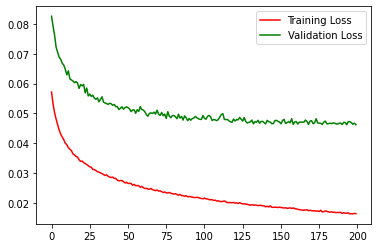

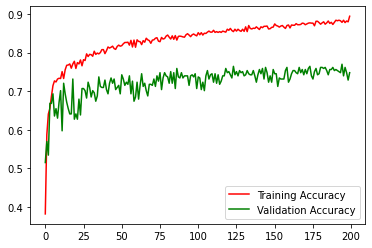

In [227]:
plt.figure()        
plt.plot(range(len(losses_train)),losses_train,color="red",label="Training Loss")
plt.plot(range(len(losses_val)),losses_val,color="green",label="Validation Loss")
_ = plt.legend(loc='best')

plt.figure()
plt.plot(range(len(acc_train)),acc_train,color="red",label="Training Accuracy")
plt.plot(range(len(acc_val)),acc_val,color="green",label="Validation Accuracy")
_ = plt.legend(loc='best')


Loss: 0.0639 Acc: 0.7836


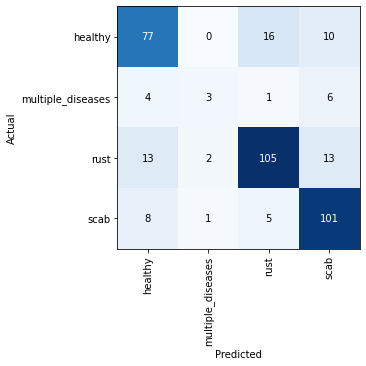

In [204]:
predictions, all_proba, all_classes = test_model(best_model_resnet50,
                                                 loaderfeat50_valid,
                                                 dset_sizes['valid'],
                                                 criterion)

cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

In [0]:
conv_feat50_test,labels50_test = preconvfeat_resnet(dataloader_test, resnet50)

datasetfeat50_test = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_test,labels_test)]
datasetfeat50_test = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat50_test]
loaderfeat50_test = torch.utils.data.DataLoader(datasetfeat50_test, batch_size=5, shuffle=False)

predictions, all_proba = test_model(best_model_resnet50,
                                    loaderfeat50_test,
                                    dset_sizes['test'],
                                    criterion,
                                    test=True)

create_submission_file(all_proba)

## StratifiedKFolds ResNet Backbone

In [0]:
train_df = pd.read_csv(os.path.join(DRIVE_DIR, 'train_original.csv'))

train_labels = train_df.iloc[:, 1:].values
train_y = train_labels[:, 2] + train_labels[:, 3] * 2 + train_labels[:, 1] * 3

In [0]:
class_sample_count = train_df[CATEGORIES].sum(axis=0)
weights = np.sum(class_sample_count)/class_sample_count.values
weights = torch.FloatTensor(weights).to(DEVICE)

In [0]:
submissiondf = pd.read_csv(os.path.join(DRIVE_DIR,"sample_submission.csv"))
submissiondf.iloc[:,1:] = 0

In [0]:
RESNET_BACKBONE = "resnet34"

if RESNET_BACKBONE == "resnet18":
    backbone = models.resnet18(pretrained=True)
    backbone.to(DEVICE)
elif RESNET_BACKBONE == "resnet34":
    backbone = models.resnet34(pretrained=True)
    backbone.to(DEVICE)
elif RESNET_BACKBONE == "resnet50":
    backbone = models.resnet50(pretrained=True)
    backbone.to(DEVICE)
else:
    raise "Choose Valid ResNet Backbone"

In [152]:
dtype=torch.float

conv_feat_test,labels_test = preconvfeat_resnet(dataloader_test, backbone)

datasetfeat_test = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_test,labels_test)]
datasetfeat_test = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_test]
loaderfeat_test = torch.utils.data.DataLoader(datasetfeat_test, batch_size=5, shuffle=False)

In [0]:
N_FOLDS = 6

folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)
oof_preds = np.zeros((1, train_df.shape[0]))

In [185]:
N_EPOCHS = 50
train_results = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_y)):
    print("Fold {}/{}".format(i_fold + 1, N_FOLDS))

    # ============================================================================================================================#
    # Initiliaze Training & Validation Set
    valid = train_df.iloc[valid_idx]
    valid.reset_index(drop=True, inplace=True)

    train = train_df.iloc[train_idx]
    train.reset_index(drop=True, inplace=True)    

    dataset_train = PlantDataset(df=train, transforms=transforms_imagenet)
    dataset_valid = PlantDataset(df=valid, transforms=transforms_imagenet)

    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=24, num_workers=6, shuffle=True)
    dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=10, num_workers=6, shuffle=False)

    # Compute ResNet50 Features
    conv_feat_train,labels_train = preconvfeat_resnet(dataloader_train, backbone)
    conv_feat_valid,labels_valid = preconvfeat_resnet(dataloader_valid, backbone)

    dtype=torch.float

    datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
    datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
    loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=24, shuffle=True)

    datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
    datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
    loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=16, shuffle=False)

    # ============================================================================================================================#
    # Train the i-Fold

    if RESNET_BACKBONE == "resnet18":
        model = nn.Sequential(nn.Linear(512, len(CATEGORIES)),
                            nn.LogSoftmax(dim=1))
    elif RESNET_BACKBONE == "resnet34":
        model = nn.Sequential(nn.Linear(512, len(CATEGORIES)),
                            nn.LogSoftmax(dim=1))
    elif RESNET_BACKBONE == "resnet50":
        model = nn.Sequential(nn.Linear(2048, len(CATEGORIES)),
                            nn.LogSoftmax(dim=1))
    else:
        raise "Choose Valid ResNet Backbone"

    model.to(DEVICE)

    criterion = nn.NLLLoss(weight=weights)
    plist = [{'params': model.parameters(), 'lr': 5e-5}]
    optimizer = torch.optim.Adam(plist, lr=5e-5)
    
    val_preds, train_fold_results = train_one_fold(i_fold, 
                                                   model, 
                                                   criterion, 
                                                   optimizer,
                                                   N_EPOCHS, 
                                                   loaderfeat_train, 
                                                   loaderfeat_valid,
                                                   len(dataset_train),
                                                   len(dataset_valid))
    
    oof_preds[0, valid_idx] = val_preds.numpy()
    
    train_results = train_results + train_fold_results

    # ============================================================================================================================#
    # Compute Predictions

    model.eval()
    test_preds = None

    for step, batch in enumerate(loaderfeat_test):

        inputs = batch[0]
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            probas = torch.exp(outputs).cpu()
            if test_preds is None:
                test_preds = probas
            else:
                test_preds = torch.cat((test_preds, probas), dim=0)
    
    # ============================================================================================================================#
    # Save predictions per fold
    submissiondf[CATEGORIES] = test_preds
    submissiondf.to_csv('submission_fold_{}.csv'.format(i_fold+1), index=False)

Fold 1/6



Fold 2/6



Fold 3/6



Fold 4/6



Fold 5/6



Fold 6/6


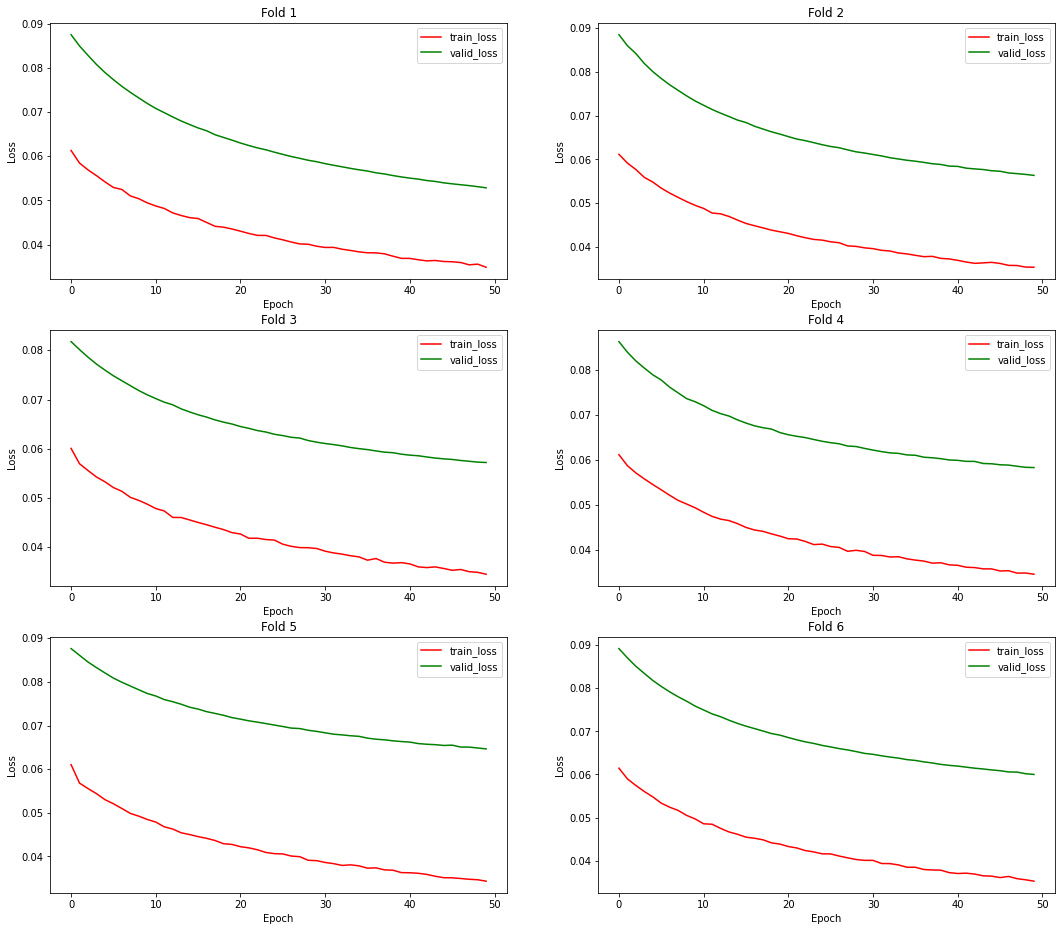

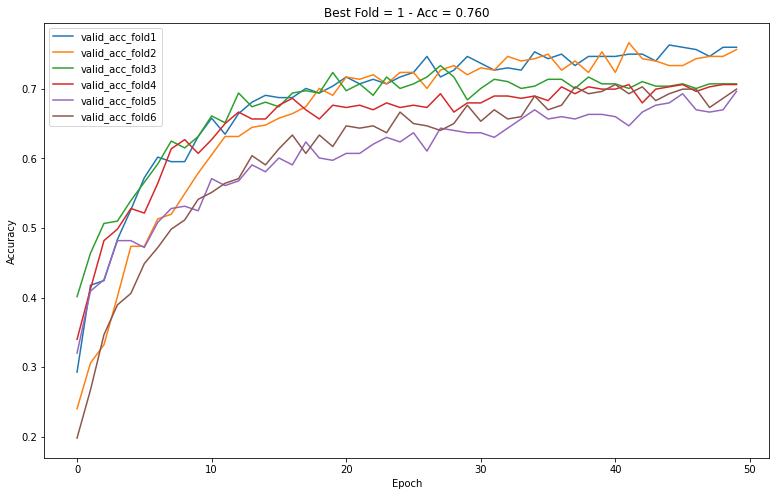

In [186]:
train_history={}
for i in range(N_FOLDS):
    fold_i_history = {
        'epoch':[],
        'train_loss':[],
        'valid_loss':[],
        'valid_acc':[]
    }
    train_history[i]=fold_i_history

for i in range(len(train_results)):
    fold = train_results[i]['fold']

    train_history[fold]['epoch'].append(train_results[i]['epoch'])
    train_history[fold]['train_loss'].append(train_results[i]['train_loss'])
    train_history[fold]['valid_loss'].append(train_results[i]['valid_loss'])
    train_history[fold]['valid_acc'].append(train_results[i]['valid_acc'])

plt.figure(figsize=(18,16))
for i in range(N_FOLDS):
    plt.subplot(3,2,i+1)
    plt.plot(train_history[i]['epoch'],train_history[i]['train_loss'], color='red', label='train_loss')
    plt.plot(train_history[i]['epoch'],train_history[i]['valid_loss'], color='green', label='valid_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss',rotation=90)
    plt.legend()
    plt.title('Fold {}'.format(i+1))

plt.figure(figsize=(13,8))
acc = 0
best_fold = None
for i in range(N_FOLDS):
    plt.plot(train_history[i]['epoch'],train_history[i]['valid_acc'], label='valid_acc_fold{}'.format(i+1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if train_history[i]['valid_acc'][-1]>acc:
        best_fold = i
        acc = train_history[i]['valid_acc'][-1]
plt.title("Best Fold = {} - Acc = {:.3f}".format(best_fold+1, acc));